# Описание проекта

Интернет-магазин хочет повысить эффективность работы с целью увеличения выручки.

Задачи проекта:
- приоритизировать гипотезы 
- запустить A/B-тест
- проанализировать результаты

# Исходные данные

Список гипотез (файл hypothesis.csv)

- Hypothesis — краткое описание гипотезы
- Reach — охват пользователей по 10-балльной шкале
- Impact — влияние на пользователей по 10-балльной шкале
- Confidence — уверенность в гипотезе по 10-балльной шкале
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале

Информация о заказах пользователей в интернет-магазине (файл orders.csv)

- transactionId — идентификатор заказа
- visitorId — идентификатор пользователя, совершившего заказ
- date — дата, когда был совершён заказ
- revenue — выручка заказа
- group — группа A/B-теста, в которую попал заказ

Информация о посещениях пользователями интернет-магазина (файл visitors.csv)

- date — дата
- group — группа A/B-теста
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

# Ход исследования

- Первый этап - приотеризация гипотез
- Второе этап - A/B-тестирование: предобработка данных, запуск тестирования, анализ результатов

Загрузим нужные для работы библиотеки

In [13]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()
import scipy.stats as stats

Чтобы прочитать гипотезы корректно установим комфортную ширину столбца

In [14]:
pd.options.display.max_colwidth = 200

## Часть 1. Приоритизация гипотез

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.
Задача:

- Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
- Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
- Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

Для начала загрузим датафрейм с гипотезами и выведем его на экран.

In [15]:
try:
    data_h = pd.read_csv('/datasets/hypothesis.csv', sep=',')

except:
    data_h = pd.read_csv('/Users/damayboroda/study/data_for_projects/hypothesis.csv', sep=',')

display(data_h)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Фреймворк ICE для приоритизации гипотез

In [16]:
data_h['ICE'] = (data_h['Impact'] * data_h['Confidence']) / data_h['Efforts']

In [17]:
display(data_h[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).style.background_gradient(subset='ICE', cmap='inferno'))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


### Фреймворк RICE для приоритизации гипотез

In [18]:
data_h['RICE']= (data_h['Reach'] * data_h['Impact'] * data_h['Confidence']) / data_h['Efforts']

In [19]:
display(data_h[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False).reset_index(drop=True).style.background_gradient(subset='RICE', cmap='cool'))

,Hypothesis,RICE
0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000000
1,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000000
2,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000000
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000000
4,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
5,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000000
6,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000000
7,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000000
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000000


### Объединенные фреймворки для приоретизации гипотез

### Выводы по приоритизации гипотез

У нас поменялась первая тройка гипотез, если сравнивать фреймворки ICE и RICE.
- Гипотеза 8 была №1 в ICE, стала только № 5 в RICE. В RICE № 1 - гипотеза 7 с уверенным отрывом (в 2 раза) от других.
- Гипотеза 0 была № 2 в ICE, опустилась на строку в RICE и стала № 3. В RICE № 2 - гипотеза 2.
- Гипотеза 7 была № 3 в ICE, стала № 1 в RICE.

Исходя из обоих фреймворков гипотезы 7,2,0,6,8 более приоритетны, гипотезы 3,1,5,4 - менее приоритетны.
Изменения в приоритизации связаны в первую очередь со значением параметра Reach. Чем больше охват - тем больше приоритезация. 
Действительно, гипотеза 8 (Запустить акцию, дающую скидку на товар в день рождения) имеет параметр Reach = 1. Что и опустило ее с первого места на 5.


In [20]:
lebel = data_h.Hypothesis.to_list()
series1=np.round(data_h['ICE'].to_list(), decimals=3)
series2=np.round(data_h['RICE'].to_list(), decimals=3)

In [21]:
# Создание новых значений для столбца 'Hypothesis'
new_labels = [f'H{i}' for i in range(1, len(lebel) + 1)]

# Обновление значений столбца 'Hypothesis'
lebel = new_labels

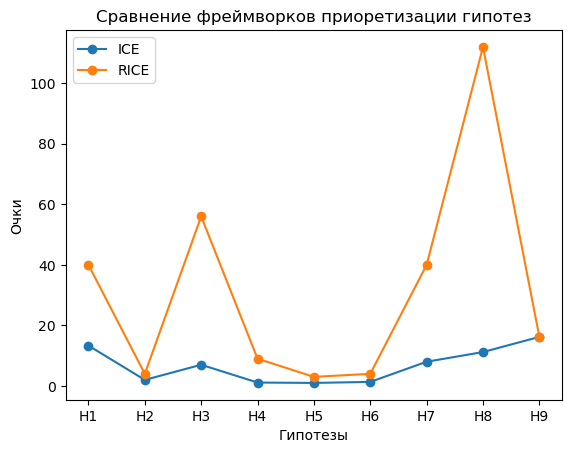

In [22]:
# Строим график

x = range(len(series1))

plt.plot(x, series1, marker='o', label='ICE')
plt.plot(x, series2, marker='o', label='RICE')

# Добавление названий гипотез на ось x
plt.xticks(x, lebel)

plt.legend()
plt.title('Cравнение фреймворков приоретизации гипотез')
plt.xlabel('Гипотезы')
plt.ylabel('Очки')

plt.show()



 Из графика-сравнения фреймворков приоритезации гипотез видно, как изменилось количество очков для гипотез № 1, 3, 7,8. А гипотезы № 2, 5, 6 и 9 практически не изменились.

## Часть. Анализ A/B-теста

Задача
Проанализируйте A/B-тест:
- Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
- Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
- Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
- Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.
- Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.
- Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
- Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
- Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
- Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
- Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.
- Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
- Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.
- Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
- Примите решение по результатам теста и объясните его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

### Подготовка данных

Для начала загрузим результаты A/B-теста и посмотрим на данные

Напишем функцию для вывода данных на экран

In [23]:
def show_info(df):
    print(df.info())
    print('----------')
    display(df.head(10))

Выведем на экран информацию о датафрейме с заказами

In [24]:
try:
    orders = pd.read_csv('/datasets/orders.csv', sep=',')

except:
    orders = pd.read_csv('/Users/damayboroda/study/data_for_projects/orders.csv', sep=',')

show_info(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
----------


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


Как видно, столбец с датой задан числовым форматом, приведет его к формату даты

In [25]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Проверим на полные дубликаты

In [26]:
orders.duplicated().sum()

0

Полных дубликатов не обнаружено

Изучим данные

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- revenue — выручка с заказа (средний чек);
- date — дата заказа.
- group — группа A/B-теста (A или B);

In [27]:
try:
    visitors = pd.read_csv('/datasets/visitors.csv', sep=',')

except:
    visitors = pd.read_csv('/Users/damayboroda/study/data_for_projects/visitors.csv', sep=',')

show_info(orders)
show_info(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None
----------


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
----------


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Аналогично для даты поменяем формат

In [28]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Проверим на полные дубликаты

In [29]:
visitors.duplicated().sum()

0

Не обнаружено

Изучим данные

- date — дата;
- group — группа A/B-теста (A или B);
- visitors — количество посетителей интернет-магазина в определённой группе A/B-теста в указанную дату.

### Анализ A/B-теста

Перед тем, как приступить к анализу, необходимо проверить, что каждому клиенту присвоена группа либо A, либо B.

In [30]:
orders_A = orders[orders['group'] == 'A'] 
orders_B = orders[orders['group'] == 'B']

orders_AB = orders_A.merge(orders_B, on='visitorId', how='inner') # объединение таблиц по общему visitor_id
orders_AB.groupby('visitorId').agg({'visitorId':'nunique'}) # visitorId, которые есть и в заказах группы А, и в заказах группы B.

,visitorId
visitorId,
8300375,1
199603092,1
232979603,1
237748145,1
276558944,1
351125977,1
393266494,1
457167155,1
471551937,1


Получается, что 58 клиентов есть как в группе А, так и в группе B. Придется удалить их из анализа, так как мы не знаем, как клиенты распределялись по группам.

In [31]:
orders_AB = orders_AB['visitorId'].unique() # создание списка уникальных наименований visitorId из orders_AB
orders = orders.query('visitorId not in @orders_AB').reset_index(drop=True) # исключение этих клиентов из orders

#### Создание датафрейма с кумулятивными данными

Чтобы построить графики, нужно собрать кумулятивные данные. 
Объявим датафрейм cumulativeData со столбцами: 
- date — дата;
- group — группа A/B-теста (A или B);
- orders — кумулятивное количество заказов на указанную дату в указанной группе;
- buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

Создадим массив уникальных пар значений дат и групп теста методом drop_duplicates()

In [32]:
datesGroups = orders[['date','group']].drop_duplicates() 
datesGroups

,date,group
0,2019-08-15,B
6,2019-08-15,A
35,2019-08-16,A
37,2019-08-16,B
45,2019-08-01,A
...,...,...
913,2019-08-12,A
950,2019-08-13,B
952,2019-08-13,A
984,2019-08-14,B


Соберём агрегированные кумулятивные по дням данные о заказах

In [33]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина

In [34]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}), axis=1).sort_values(by=['date','group'])

Объединим два получившихся датафрейма

In [35]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


#### График кумулятивной выручки по группам

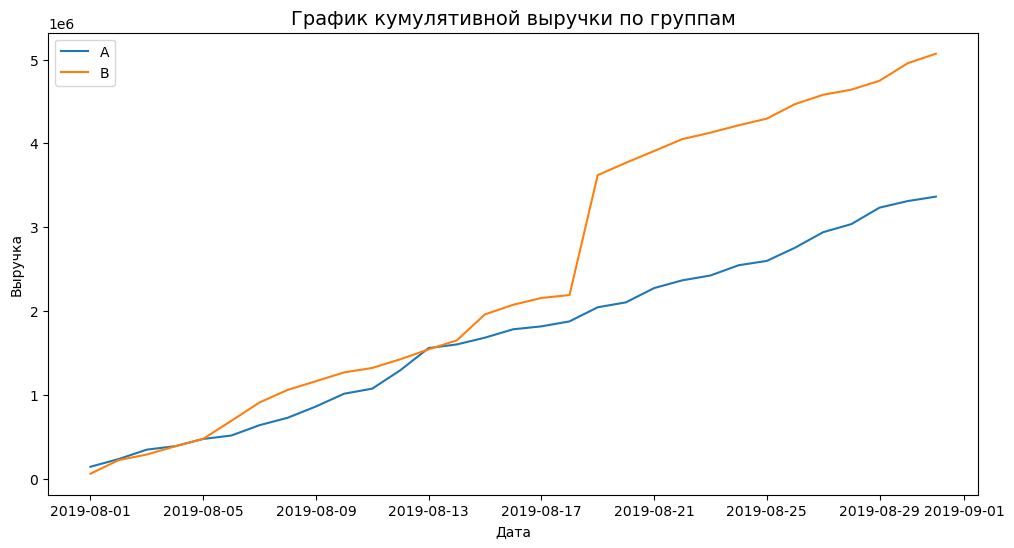

In [36]:

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

#Задаем замер графика
plt.figure(figsize=(12,6))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам', size=14)
plt.xlabel("Дата")
plt.ylabel("Выручка")
plt.legend()
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. Хороший знак.
Однако график выручки группы B 18 августа резко растет. Это может сигнализировать о всплесках числа заказов с этого дня, либо о появлении очень дорогих заказов в выборке. 
Из графика видно, что выручка группы B с этого момента значительно выше выручки группы A.

 #### График кумулятивного среднего чека по группам

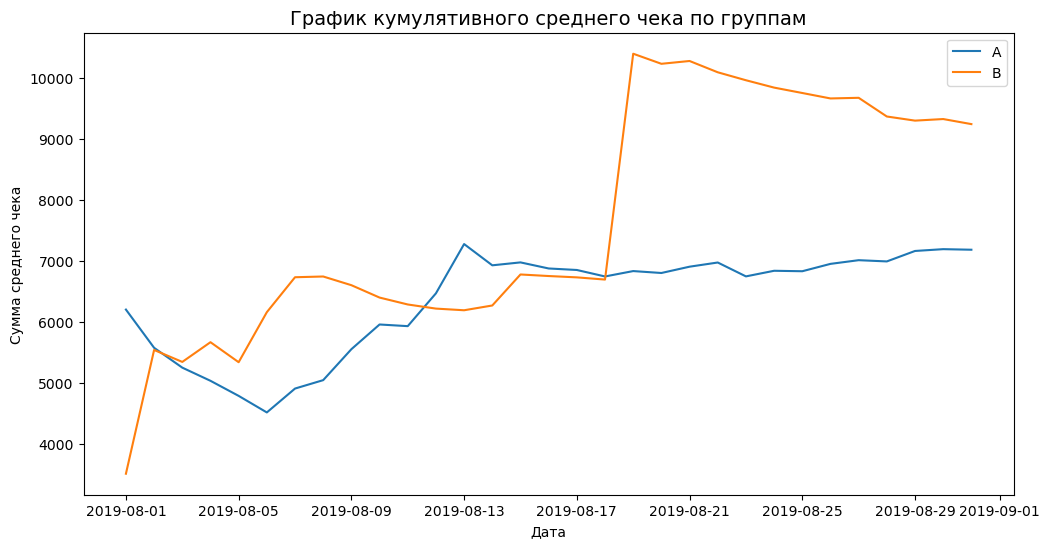

In [37]:
# Задаем размер графика
plt.figure(figsize=(12,6))

# Строим график среднего чека группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')

# Строим график среднего чека группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам', size=14)
plt.xlabel("Дата")
plt.ylabel("Сумма среднего чека")
plt.legend()
plt.show()

Средний чек тоже становится равномерным ближе к концу теста: продолжает расти для группы A и снижается для группы B. Опять же рост среднего чека с 7000 до 10000 18 августа для группы B. Возможно, в группу B во второй половине теста попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.


#### График относительного изменения кумулятивного среднего чека группы B к группе A

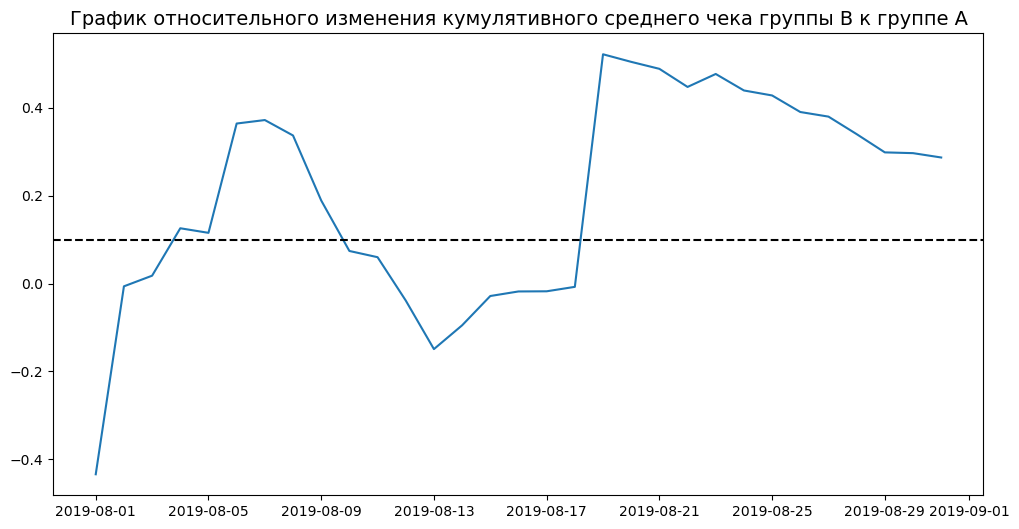

In [38]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# Задаем размер графика
plt.figure(figsize=(12,6))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', size=14)
# добавляем ось X
plt.axhline(y=0.1, color='black', linestyle='--')
plt.show()

В нескольких точках график различия между сегментами резко «скачет». Это может говорить о выбросах, пока их не проверить - сложно говорить, что средний чек группы B значимо положительно отличается от среднего чека группы А.

#### График кумулятивного среднего количества заказов на посетителя (конверсии) по группам

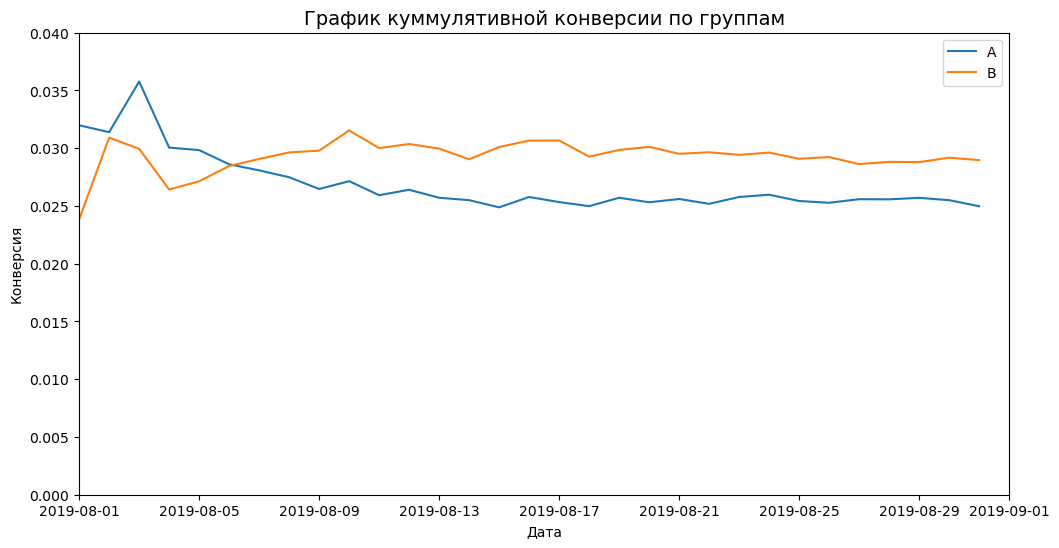

In [39]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# Задаем размер графика
plt.figure(figsize=(12,6))

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График куммулятивной конверсии по группам', size=14)
plt.xlabel("Дата")
plt.ylabel("Конверсия")
plt.legend()
plt.axis(["2019-08-01", '2019-09-01', 0, 0.04])
plt.show()

Сначала конверсия группы А была выше конверсии группы B, но затем конверсия группы B вырвалась вперёд и зафиксировалась, а конверсия группы A просела и также зафиксировалась.

 #### График относительного изменения кумулятивного среднего количества заказов на посетителя (конверсии) группы B к группе A

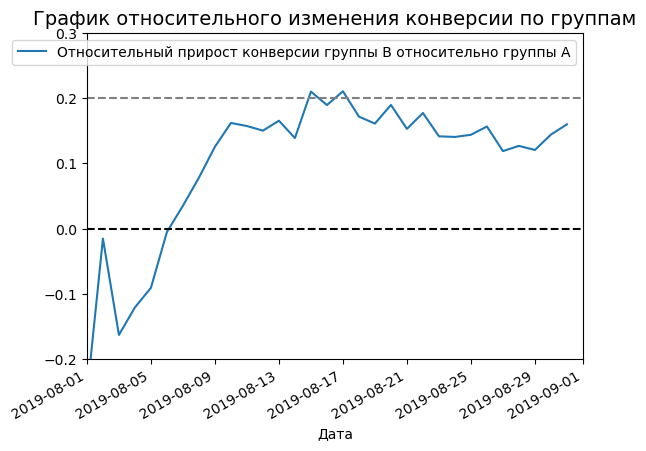

In [40]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
fig = plt.figure()
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.title('График относительного изменения конверсии по группам', size=14)
plt.xlabel("Дата")

plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.2, 0.3])
fig.autofmt_xdate()

В начале группа В уступала группе А незначительно, затем В вырвалась сильно вперёд. В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Стоит проанализировать аномалии, возможно, они изменят картину.

#### Точечный график количества заказов по пользователям

In [41]:
ordersByVisitors = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByVisitors.columns = ['visitorId', 'orders']

print(ordersByVisitors.sort_values(by='orders', ascending=False).head(10)) 

      visitorId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


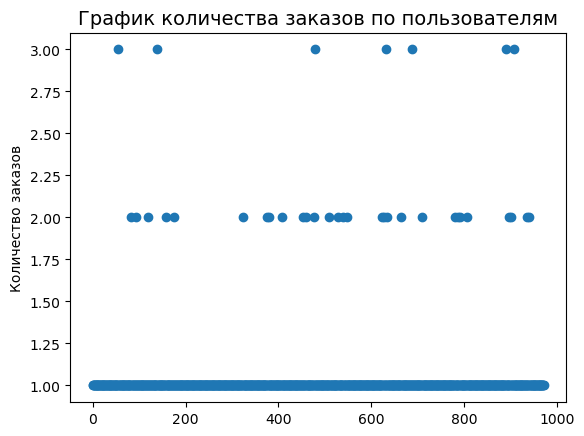

In [42]:
x_values = pd.Series(range(0,len(ordersByVisitors)))

plt.scatter(x_values, ordersByVisitors['orders'])
plt.title('График количества заказов по пользователям', size=14)
plt.ylabel("Количество заказов")
plt.show()

График показывает, что редко, когда посетители оформляют больше 1 заказа. Посчитаем выборочные перцентили количества заказов на одного пользователя.

#### 95-й и 99-й перцентили количества заказов на пользователя. Граница для определения аномальных пользователей.

In [43]:
print(np.percentile(ordersByVisitors['orders'], [95, 99])) 

[1. 2.]


Менее 5% клиентов совершают более 1 заказов. Менее 1% клиентов совершают 2 заказа. Таким образом, граница аномальных пользователей - 2 заказа.

#### Точечный график стоимостей заказов

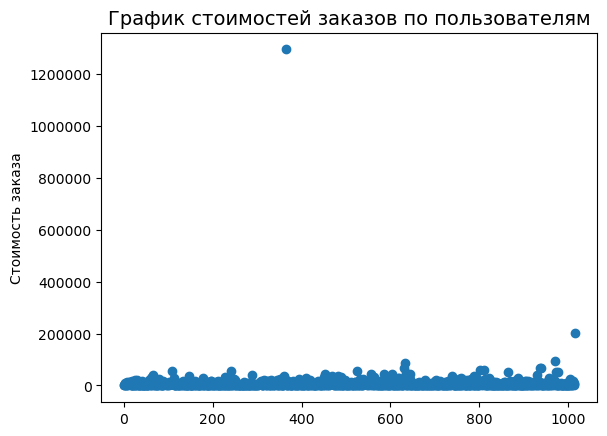

In [44]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.ticklabel_format(style='plain')
plt.title('График стоимостей заказов по пользователям', size=14)
plt.ylabel("Стоимость заказа")
plt.show()

Визуально 2 выбораса выделяются - кто-то закупил товар более, чем на 1200000 и более, чем на 200000.

#### 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [45]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Менее 5% оформили заказ стоимостью более 26785 руб, менее 1% - стоимостью 53904 руб. Граница аномальных значений - 30000.

#### Подготовка к расчету статистических значимостей

Соберем сводную таблицу data со всеми необходимыми данными

In [46]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitorId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,22,162043,42,234381,39,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,53,288850,507,509,1845,1803
3,2019-08-04,11,41176,13,96890,77,388030,66,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,87,475648,756,707,3318,3280


Описание полученных столбцов:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

#### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаем статистическую значимость различия в среднем количестве заказов между группами.
Создадим переменные ordersByVisitorsA и ordersByVisitorsB со столбцами ['visitorId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

In [47]:
ordersByVisitorsA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByVisitorsA.columns = ['visitorId', 'orders']

ordersByVisitorsB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByVisitorsB.columns = ['visitorId', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [48]:
sampleA = pd.concat([ordersByVisitorsA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByVisitorsA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByVisitorsB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByVisitorsB['orders'])), name='orders')],axis=0)

In [49]:
sampleA.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

Сформулируем гипотезы.

- H0: различий в конверсии (в среднем количестве заказов на посетителя) между группами по сырым данным нет.
- H1: различия в конверсии (в среднем количестве заказов на посетителя) между группами по сырым данным есть.

Применим статистический критерий Манна-Уитни, чтобы оценить различия в количестве заказов между группами A и B. 

In [50]:
alpha = .05 
results = stats.mannwhitneyu(sampleA, sampleB)


print('p-значение: ', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

print('относительный выигрыш группы B:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-значение:  0.011
Отвергаем нулевую гипотезу
относительный выигрыш группы B: 0.160


По «сырым» данным есть значимые различия в среднем количестве заказов в группах A и B. Первое число — p-value = 0.011 < 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный выигрыш группы B равен 16% — второе число в выводе. Возможно, что выбросы не сильно влияют на данные, но проверим это позже.

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы.

- H0: различий в среднем чеке заказа между группами нет по сырым данным.
- H1: различия в среднем чеке заказа между группами есть по сырым данным.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. 
А ещё найдём относительные различия в среднем чеке между группами.

In [51]:
alpha = .05 
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])


print('p-значение: ', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

print('относительный выигрыш группы B:', "{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))


p-значение:  0.829
Не получилось отвергнуть нулевую гипотезу
относительный выигрыш группы B: 0.287


Наблюдаемое различие в 28.7% в пользу группы B в среднем чеке не является стат. значимым. P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 

#### Вычисление аномальных пользователей

In [52]:
orders_lim = 2
revenue_lim = 30000

visitorsWithManyOrders = pd.concat(
    [
        ordersByVisitorsA[ordersByVisitorsA['orders'] > orders_lim]['visitorId'],
        ordersByVisitorsB[ordersByVisitorsB['orders'] > orders_lim]['visitorId'],
    ],
    axis=0,
)
visitorsWithExpensiveOrders = orders[orders['revenue'] > revenue_lim]['visitorId']
abnormalVisitors = (
    pd.concat([visitorsWithManyOrders, visitorsWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalVisitors.head(5))
print(abnormalVisitors.shape[0])

937    148427295
792    204675465
33     249864742
586    358944393
557    382846391
Name: visitorId, dtype: int64
49


49 клиентов с аномальными значениями

#### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Подготовим выборки количества заказов по пользователям по группам теста

In [53]:
sampleAFiltered = pd.concat(
    [
        ordersByVisitorsA[
            np.logical_not(ordersByVisitorsA['visitorId'].isin(abnormalVisitors))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByVisitorsA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByVisitorsB[
            np.logical_not(ordersByVisitorsB['visitorId'].isin(abnormalVisitors))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByVisitorsB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам

Сформулируем гипотезы.

- H0: различий в конверсии (в среднем количестве заказов на посетителя) между группами по очищенным данным нет.
- H1: различия в конверсии (в среднем количестве заказов на посетителя) между группами по очищенным данным есть.

In [54]:
alpha = .05 
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)


print('p-значение: ', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

print('относительный выигрыш группы B:', "{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-значение:  0.010
Отвергаем нулевую гипотезу
относительный выигрыш группы B: 0.187


Cреднее количество заказов группы B выше среднего количества заказов группы A - на 18.7% (а было - 16%)
P-value немного уменишилось и значительно меньше 0.05. Значит, нулевую гипотезу отвергаем и считаем, что в среднем количестве заказов есть различия. Очистка выбросов скорректировала разницу и утвердила мнение, что количество среднее количество заказов группы B значимо превышает среднее количество заказов группы A.

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Сформулируем гипотезы.

- H0: различий в среднем чеке заказа между группами нет по очищенным данным.
- H1: различия в среднем чеке заказа между группами есть по очищенным данным.

In [55]:
alpha = .05 
results = stats.mannwhitneyu(orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalVisitors)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalVisitors)),
                )
            ]['revenue'])


print('p-значение: ', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

print('относительный выигрыш группы B:', "{0:.3f}".format(orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalVisitors)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalVisitors)),
            )
        ]['revenue'].mean()
        - 1))


p-значение:  0.741
Не получилось отвергнуть нулевую гипотезу
относительный выигрыш группы B: -0.027


Cредний чек группы B даже ниже среднего чека группы A - на 2.7%. Разницы теперь нет практически никакой - благодаря очистке выбросов.

P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет, как и при сырых данных. 


Значим мы можем говорить, что разницы между средними чеками в группах А и B нет.

### Выводы A/B-тестирования

- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
- Нет статистически значимого различия по среднему чеку между группами как по сырым данным, так и после удаления аномалий.
- Результаты группы B лучше группы A по конверсии (среднему количеству заказов на пользователя): имеют тенденцию роста.
- По графику среднего чек для обеих групп нельзя делать выводы, он не установился ни для одной из групп.

**Решение**: в соответствии с полученными выводами остановить тест и признать победу группы B.
